# 🏷️ K-Nearest Neighbors Classification

In this notebook, we explore K-Nearest Neighbors classification with:

- **Synthetic data** generated with Gaussian noise
- **SKLearn**'s built-in `KNeighborsClassifier`
- Implementing a custom **classic k-NN**
- Implementing a **weighted k-NN with Gaussian kernel**
  
Evaluation metrics and visualizations are included for comparison.

In [61]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from colorama import Fore, Style
from numpy.typing import NDArray
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    f1_score,
    precision_score,
    recall_score,
)
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier

## 🛠️ Utils

In [62]:
def evaluate_classification(
    y_true: NDArray[np.int64], y_pred: NDArray[np.int64]
) -> dict[str, float]:
    """Print and return classification metrics.

    Args:
        y_true (NDArray[np.int64]): Ground truth labels.
        y_pred (NDArray[np.int64]): Predicted labels.

    Returns:
        dict[str, float]: Dictionary with accuracy, precision, recall, and F1-score.
    """
    accuracy: float = accuracy_score(y_true, y_pred)
    precision: float = precision_score(
        y_true, y_pred, average="weighted", zero_division=0
    )
    recall: float = recall_score(y_true, y_pred, average="weighted", zero_division=0)
    f1: float = f1_score(y_true, y_pred, average="weighted", zero_division=0)

    print(f"{Fore.CYAN}Accuracy:  {Style.RESET_ALL}{accuracy:.4f}")
    print(f"{Fore.CYAN}Precision: {Style.RESET_ALL}{precision:.4f}")
    print(f"{Fore.CYAN}Recall:    {Style.RESET_ALL}{recall:.4f}")
    print(f"{Fore.CYAN}F1 Score:  {Style.RESET_ALL}{f1:.4f}")

    return {"accuracy": accuracy, "precision": precision, "recall": recall, "f1": f1}

In [63]:
def plot_confusion_matrix(y_true: NDArray[np.int64], y_pred: NDArray[np.int64]) -> None:
    """Display a confusion matrix using seaborn heatmap.

    Args:
        y_true (NDArray[np.int64]): True labels.
        y_pred (NDArray[np.int64]): Predicted labels.
    """
    conf_matrix = confusion_matrix(y_true, y_pred)

    sns.heatmap(
        conf_matrix,
        annot=True,
        fmt="d",
        cmap="Blues",
        cbar=False,
    )
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.title("Confusion Matrix")
    plt.show()


def plot_clusters(
    data: NDArray[np.float64],
    centers: NDArray[np.float64],
    X_test: NDArray[np.float64],
    predicted: NDArray[np.int64],
    labels: NDArray[np.int64],
    subtitle: str = "Clustering Overview",
) -> None:
    """Plot original clusters and predictions on test data.

    Args:
        data (NDArray[np.float64]): Original dataset (n_samples, 2).
        centers (NDArray[np.float64]): Cluster centers (n_clusters, 2).
        X_test (NDArray[np.float64]): Test data points (n_test_samples, 2).
        predicted (NDArray[np.int64]): Predicted cluster labels or outputs.
        labels (NDArray[np.int64]): Ground truth labels for training data.
        subtitle (str): Title for the entire plot.
    """
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    fig.suptitle(subtitle)

    # Plot original data and cluster centers
    sns.scatterplot(
        x=data[:, 0],
        y=data[:, 1],
        hue=labels,
        alpha=0.5,
        palette="Set2",
        ax=axes[0],
    )
    axes[0].scatter(
        centers[:, 0],
        centers[:, 1],
        c="black",
        s=100,
        marker="x",
        label="Centers",
    )
    axes[0].set_title("Original Data and Cluster Centers")
    axes[0].legend()

    # Plot predictions
    axes[1].scatter(
        X_test[:, 0],
        X_test[:, 1],
        c=predicted,
        cmap="tab10",
        alpha=0.5,
    )
    axes[1].set_title("Predictions on Test Data")

    plt.tight_layout()
    plt.show()

---

In [64]:
def minkowski_metric(
    X_train: NDArray[np.float64], x_new: NDArray[np.float64], p: float = 2.0
) -> NDArray[np.float64]:
    """Compute the Minkowski distance between two points.

    Args:
        X_train (NDArray): Training samples, shape (n_samples, n_features).
        x_new (NDArray): Single test sample, shape (n_features,).
        p (float, optional): Order of the Minkowski distance (default 2 = Euclidean).

    Returns:
        NDArray: Distances from x_new to each sample in X_train.
    """
    return np.sum(np.abs(X_train - x_new) ** p, axis=1) ** (1 / p)

## 📊 Generate Dataset

In [65]:
def generate_data(
    n_per_cluster: int,
    num_clusters: int,
    space_size: float,
    noise_level: float = 1.0,
    dim: int = 2,
    seed: int = 42,
) -> tuple[NDArray[np.float64], NDArray[np.int32], NDArray[np.float64]]:
    """Generates synthetic data for clustering.

    Args:
        n_per_cluster (int): Number of points per cluster.
        num_clusters (int): Total number of clusters.
        space_size (float): Range for generating cluster centers.
        noise_level (float): Standard deviation of Gaussian noise.
        dim (int): Dimensionality of the data.
        seed (int): Random seed.

    Returns:
        tuple[
            data (NDArray[np.float64]): Shape (num_clusters * n_per_cluster, dim)
            labels (NDArray[np.int32]): Cluster labels
            centers (NDArray[np.float64]): Cluster center coordinates
        ]
    """
    rng = np.random.default_rng(seed)

    # Generate random cluster centers
    centers = rng.uniform(0, space_size, size=(num_clusters, dim))

    total_points = n_per_cluster * num_clusters
    data = np.empty((total_points, dim))
    labels = np.empty(total_points, dtype=np.int32)

    # Generate data points around each center
    for i, center in enumerate(centers):
        start = i * n_per_cluster
        end = start + n_per_cluster
        data[start:end] = center + rng.normal(0, noise_level, size=(n_per_cluster, dim))
        labels[start:end] = i

    return data, labels, centers


# Generate dataset
data, labels, centers = generate_data(
    n_per_cluster=1000, num_clusters=4, space_size=50, noise_level=7, dim=2, seed=412
)

In [66]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    data, labels, test_size=0.2, random_state=42
)

## ⚙️ SKLearn Model

In [67]:
# Create and train the model
model = KNeighborsClassifier(n_neighbors=5, algorithm="brute", metric="minkowski")
model.fit(X_train, y_train)

# Predict on test data
predicted = model.predict(X_test)

Accuracy:  0.9287
Precision: 0.9297
Recall:    0.9287
F1 Score:  0.9288


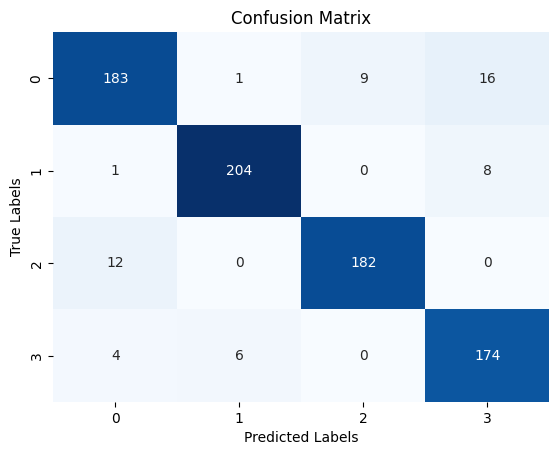

In [68]:
evaluate_classification(y_test, predicted)
plot_confusion_matrix(y_test, predicted)

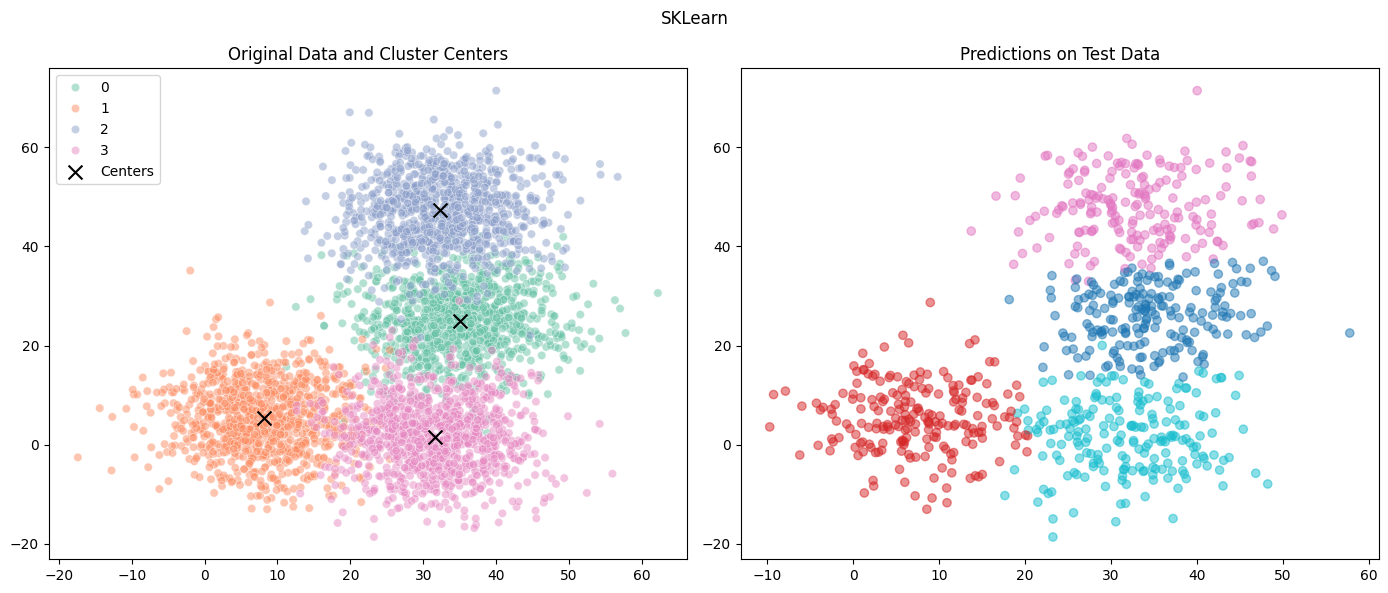

In [69]:
plot_clusters(data, centers, X_test, predicted, labels, "SKLearn")

## 🧪 Custom Implementations

### 🏘 K-nearest neighbors

In [70]:
def knn_predict(
    X_train: NDArray[np.float64],
    y_train: NDArray[np.int64],
    x_new: NDArray[np.float64],
    k_neighbors: int = 3,
    p: float = 2.0,
) -> int:
    """Predict the label for a new data point using k-NN.

    Args:
        X_train (NDArray[np.float64]): Training features, shape (n_samples, n_features).
        y_train (NDArray[np.int64]): Training labels, shape (n_samples,).
        x_new (NDArray[np.float64]): Single test sample, shape (n_features,).
        k_neighbors (int, optional): Number of neighbors to use. Defaults to 3.
        p (float, optional): Minkowski distance order. Defaults to 2.0.

    Returns:
        int: Predicted label for x_new.
    """
    distances = minkowski_metric(X_train, x_new, p)

    neighbors_idx = distances.argsort()[:k_neighbors]
    neighbor_labels = y_train[neighbors_idx]

    unique, counts = np.unique(neighbor_labels, return_counts=True)
    most_common_label = unique[np.argmax(counts)]

    return most_common_label


# Predict labels for all samples in X_test
predicted = np.array(
    [knn_predict(X_train, y_train, x_new, k_neighbors=5, p=4) for x_new in X_test]
)

Accuracy:  0.9313
Precision: 0.9318
Recall:    0.9313
F1 Score:  0.9312


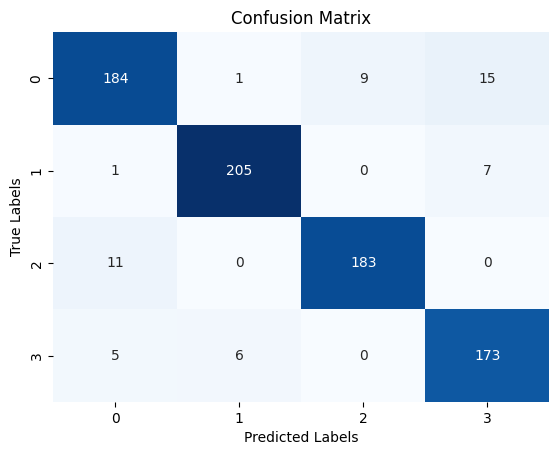

In [71]:
evaluate_classification(y_test, predicted)
plot_confusion_matrix(y_test, predicted)

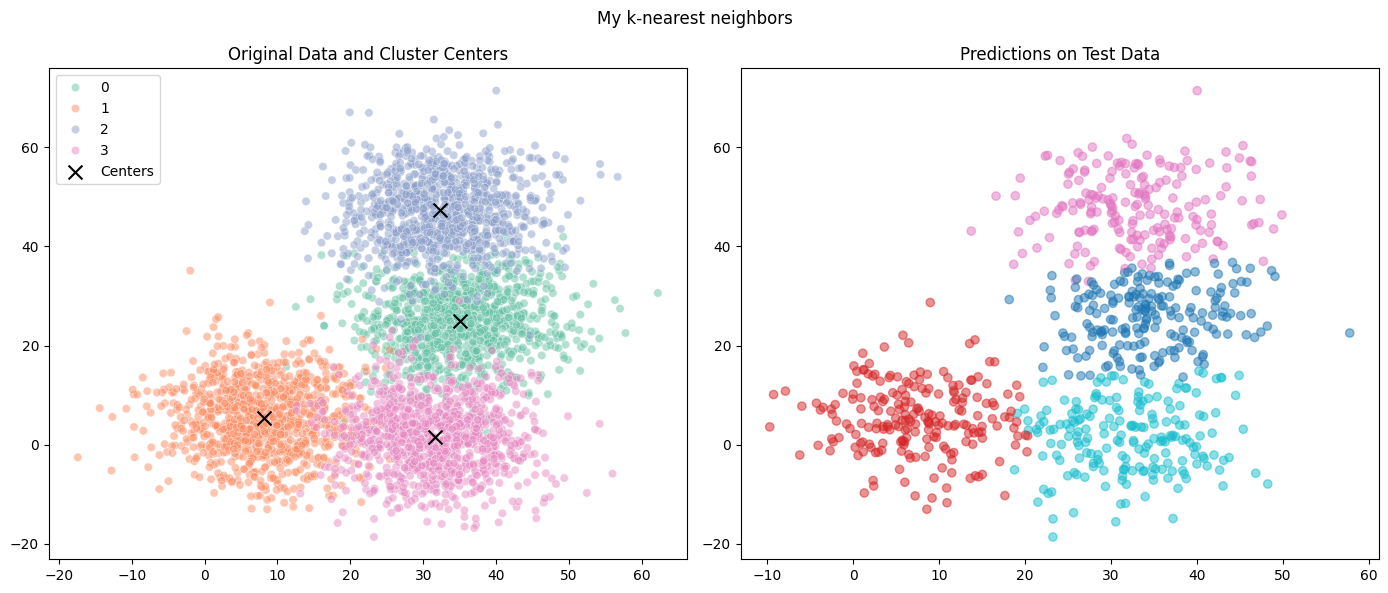

In [72]:
plot_clusters(data, centers, X_test, predicted, labels, "My k-nearest neighbors")

### ⚖️ Weighted k-nearest neighbors

In [73]:
def gaussian_kernel(t: NDArray[np.float64] | float) -> NDArray[np.float64] | float:
    """Gaussian (normal) kernel function.

    Args:
        t (NDArray[np.float64] | float): Input value(s).

    Returns:
        NDArray[np.float64] | float: Kernel-weighted value(s).
    """
    return np.exp(-(t**2) / 2) / np.sqrt(2 * np.pi)


def weighted_knn_kernel(
    X_train: NDArray[np.float64],
    y_train: NDArray[np.int64],
    X_test: NDArray[np.float64],
    k_neighbors: int = 3,
    p: float = 2.0,
    h: float = 1.0,
) -> NDArray[np.float64]:
    """Predict labels using weighted k-NN with a Gaussian kernel.

    Args:
        X_train (NDArray[np.float64]): Training features, shape (n_samples, n_features).
        y_train (NDArray[np.int64]): Training labels, shape (n_samples,).
        X_test (NDArray[np.float64]): Test features, shape (n_test_samples, n_features).
        k_neighbors (int, optional): Number of neighbors to consider. Defaults to 3.
        p (float, optional): Order of the Minkowski distance. Defaults to 2.0.
        h (float, optional): Bandwidth parameter for the Gaussian kernel. Defaults to 1.

    Returns:
        NDArray[np.float64]: Predicted labels for each sample in X_test.
    """
    y_predicted: list[float] = []

    for x_new in X_test:
        distances = minkowski_metric(X_train, x_new, p)

        neighbors_idx = distances.argsort()[:k_neighbors]
        neighbor_labels = y_train[neighbors_idx]
        neighbor_distances = distances[neighbors_idx]

        weights = gaussian_kernel(neighbor_distances / h)

        class_weights = {}
        for label, weight in zip(neighbor_labels, weights, strict=False):
            class_weights[label] = class_weights.get(label, 0) + weight

        predicted_label = max(class_weights, key=class_weights.get)
        y_predicted.append(predicted_label)

    return np.array(y_predicted)


# Predict labels for all samples in X_test
predicted = weighted_knn_kernel(X_train, y_train, X_test, k_neighbors=5, p=5, h=5.8)

Accuracy:  0.9300
Precision: 0.9306
Recall:    0.9300
F1 Score:  0.9300


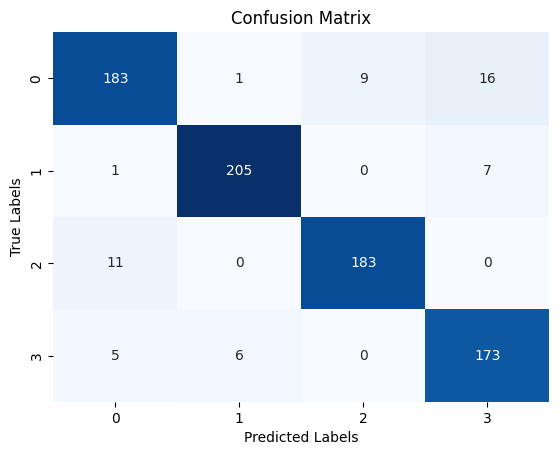

In [74]:
evaluate_classification(y_test, predicted)
plot_confusion_matrix(y_test, predicted)

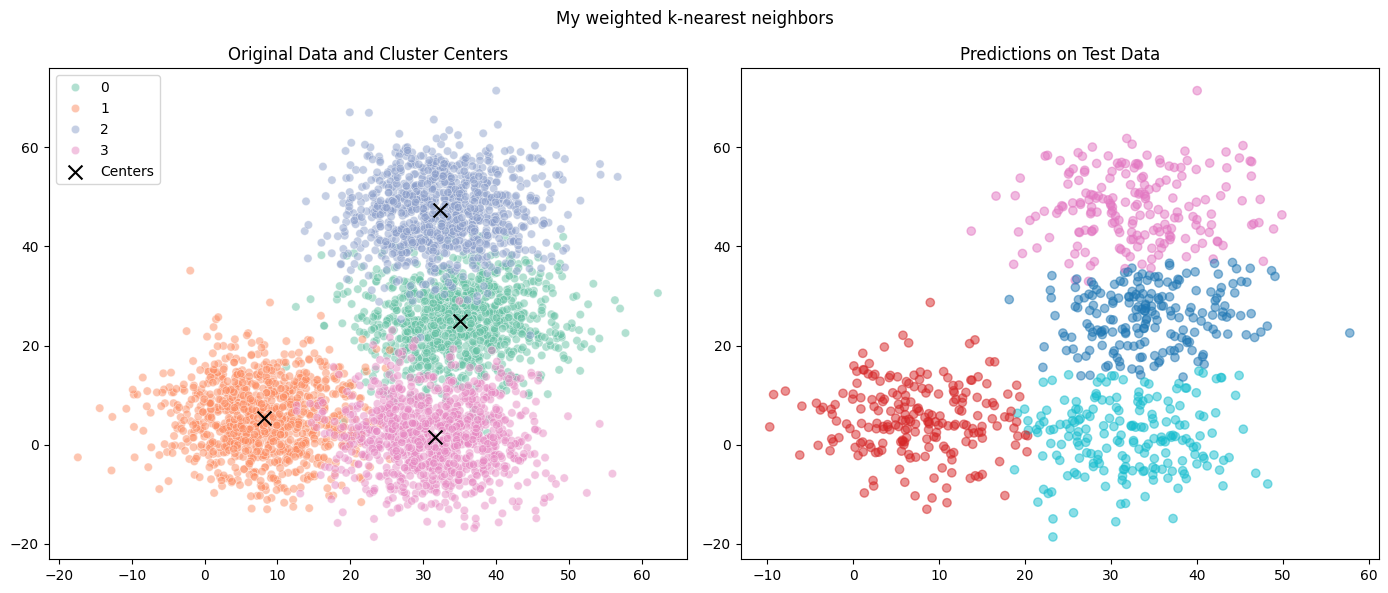

In [75]:
plot_clusters(
    data, centers, X_test, predicted, labels, "My weighted k-nearest neighbors"
)